<a href="https://colab.research.google.com/github/srilamaiti/SM_MIDS_W207_HW/blob/main/InceptionResNetV2_trainable_tl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***1. Setup***

## ***A. Installing New Libraries***

In [1]:
!pip install imgaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 36.6 MB/s 


## ***B. Importing Libraries***

### ***a. Importing General Purpose Libraries***

In [13]:
import pandas as pd
import numpy as np
import os
import random
import joblib
import glob
import random
from itertools import product
import gc
import subprocess
import shutil
import copy
import statistics as st
from scipy import stats
from pathlib import Path

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### ***b. Importing Image Processing and Visualization Libraries***

In [4]:
from imutils import rotate as rotate
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.patches as patches
from matplotlib.patches import Polygon
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from mlxtend.plotting import plot_confusion_matrix
from skimage.color import gray2rgb
import skimage.io as skio
from imgaug import augmenters as img_aug
import imgaug as iaug

### ***c. Importing Sklearn Functionalities***

In [5]:
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

### ***d. Importing Tensorflow Libraries***

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from livelossplot import PlotLossesKeras
from keras.utils.layer_utils import count_params

from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Multiply
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import PReLU
from keras.layers.core import Activation
from keras.layers.convolutional import SeparableConv1D
from keras.layers.convolutional import SeparableConv2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop

from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.densenet import *
from keras.applications.resnet import ResNet152
from keras.applications.nasnet import NASNetMobile
from keras.applications.nasnet import NASNetLarge
from keras.applications.efficientnet import EfficientNetB7
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.nasnet import preprocess_input
from keras.applications import MobileNetV2
from keras.applications.xception import Xception
from keras.applications.inception_v3 import *

from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import save_img

from tensorflow.python.ops.numpy_ops import np_config

from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler

from tensorflow.keras.losses import mae
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.losses import binary_crossentropy

from keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from keras.models import load_model


## ***C. Mounting Google Drive***

In [7]:
# Required to read the data from Kaggle
from google.colab import drive
drive.mount('/content/gdrive')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"

Mounted at /content/gdrive


## ***D. Downloading Data from Kaggle***

In [8]:
!bash /content/gdrive/MyDrive/Kaggle/download_kaggle_data.ksh

100% 6.31G/6.31G [05:08<00:00, 24.3MB/s]
100% 6.31G/6.31G [05:08<00:00, 22.0MB/s]


In [9]:
#!kaggle competitions download -c histopathologic-cancer-detection
#!unzip -o -qq \*.zip  && rm *.zip

## ***E. Defining Vartiables***

In [10]:
#sample_size = 80000
sample_size = 80000
#batch_size = 256
batch_size = 64
epochs = 10

image_size = 96
#number_of_splits = 8
number_of_splits = 4
run_mode = ['interim_test', 'final_test']

# Transfer learning model list
transfer_learning_model_list = ['VGG16', 
                                'VGG19', 
                                'DenseNet201', 
                                'InceptionV3', 
                                'ResNet50', 
                                'EfficientNetB7', 
                                'MobileNet', 
                                'Xception'
                               ]
learning_rate_list = [.01, .001, .0001, .00001]
optimizer_list = ['sgd', 'adam']
dropout_list = [.2, .4, .6]
kernel_size_list = [(3,3), (4,4), (5,5)]
dense_layer_node_list = [512, 256, 128]
fully_conneted_layer_list = [1, 2, 3]
epoch_list = [5, 10, 15, 20]

train_path = os.getcwd() + "/train/"
test_path = os.getcwd() + "/test/"

original_input_file_list = train_path + '*.tif'
original_output_file_list = test_path + '*.tif'

current_working_dir = os.getcwd()

train_label_file = 'train_labels.csv'
test_label_file = 'sample_submission.csv'

image_file_extension = '.tif'

train_files_path = os.path.join(current_working_dir, train_path)
test_files_path = os.path.join(current_working_dir, test_path)

image_processing_train_positive_path = '/content/image_processing/train/positive'
image_processing_train_negative_path = '/content/image_processing/train/negative'

image_processing_validation_positive_path = '/content/image_processing/validation/positive'
image_processing_validation_negative_path = '/content/image_processing/validation/negative'

image_processing_test_positive_path = '/content/image_processing/test/positive'
image_processing_test_negative_path = '/content/image_processing/test/negative'

image_processing_train_path = "/content/image_processing/train/"
image_processing_validation_path = "/content/image_processing/validation/"
image_processing_test_path = "/content/image_processing/test/"

random.seed(1)
random_state = 1234

dropout_rate = .5

training_accuracy_col_list   = ['training_accuracy_k' + str(k) + '_fold_accuracy' for k in range(1, number_of_splits + 1)]
validation_accuracy_col_list = ['validation_accuracy_k' + str(k) + '_fold_accuracy' for k in range(1, number_of_splits + 1)]
training_loss_col_list = ['training_loss_k' + str(k) + '_fold_loss' for k in range(1, number_of_splits + 1)]
validation_loss_col_list = ['validation_loss_k' + str(k) + '_fold_loss' for k in range(1, number_of_splits + 1)]
consolidated_df_model_kpi = pd.DataFrame()

df_model_kfold_epoch_pred_pct = pd.DataFrame()
df_model_kfold_epoch_pred_bin = pd.DataFrame()

saved_model_names_list = []

grayscale_image_augmentation_list = ['adjust_random_brightness',
                                     'adjust_random_contrast',
                                     'random_flip_left_right',
                                     'random_flip_up_down',
                                     'rotate_image_by_angle',
                                     'rotate_image_by_90_or_180_or_270_deg',
                                     'random_zoom',
                                     'resize_with_crop_or_pad'
                                    ]

## ***F. Misclenious Processing Class***

In [14]:
class misc_processing:
    """
    This class contains methods for misclenious processings.
    """
    def __init__(self):
        None
  
    def create_dir_structure(self, root_directory):
        """
        This method creates a directory tree in the form below:-
        image_processing--| train         |---positive
                          |               |---negative
                          |  
                          | validation    |---positive
                          |               |---negative
                          |
                          | test          |---positive
                          |               |---negative

        """
        dirpath = Path(root_directory)
        if dirpath.exists() and dirpath.is_dir():
            shutil.rmtree(f'{root_directory}')
        os.makedirs(f'{root_directory}', exist_ok = True)
        for sub_folder in ['train', 'validation', 'test']:
            for grp in ['positive', 'negative']:
                os.makedirs(f'{root_directory}/{sub_folder}/{grp}', exist_ok=True)

    def remove_files_from_dir(self, path):
        """
        This method deletes all files under a given path.
        """
        print()
        print("*****************************************************")
        print("*****************************************************")
        print(f"Starting to remove files under {path}...")
        shutil.rmtree(path)
        os.mkdir(path)
        print("*****************************************************")
        print("*****************************************************")
        print()
    
    def generate_fully_qualified_file_name_list(self, file_list):
        """
        This method generates a list of fully qualified file names.
        """
        qualified_file_name_list = [os.path.join(current_working_dir, train_path) + 
                                    img + 
                                    '.tif' 
                                    for img in file_list
                                   ]
        return qualified_file_name_list

    def print_image_original(self, image_file_list, label_list):
        """
        This method prints original images.
        """
        nrows, ncols = 1,4 #print first 4 images
        f, axs = plt.subplots(nrows, ncols, figsize=(14,12))
        for i, image in enumerate(image_file_list):
            axs[i].imshow(array_to_img(image))
            pf = Polygon(((32, 32), (64, 32), (64, 64), (32, 64)),
                         fc=(0.0, 0.0, 0.0, 0.0), 
                         ec=(0.0, 0.9, 0.0 ,0.9), lw=4, linestyle='--')
            pf.set_edgecolor('r')
            axs[i].add_patch(pf)
            axs[i].set(title=label_list[i])

    def print_image_in_diff_orientation(self, image_file):
        """
        This method prints images.
        """
        tf.random.set_seed(1234)
        fig = plt.figure(figsize=(14, 12))
        #fig = plt.figure()
        image = skio.imread(image_file, plugin = "tifffile")
        
        # plot original
        ax = fig.add_subplot(1, 5, 1)
        ax.imshow(array_to_img(image))
        pf = Polygon(((32, 32), (64, 32), (64, 64), (32, 64)),
                fc = (0.0, 0.0, 0.0, 0.0), 
                ec = (0.0, 0.9, 0.0 ,0.9), lw=4, linestyle='--')
        pf.set_edgecolor('r')
        ax.add_patch(pf)
        ax.set_title('Original', size=15);
        
        # resize
        ax = fig.add_subplot(1, 5, 2)
        img_resize = tf.image.resize(image, size=(224, 224))
        ax.imshow(array_to_img(img_resize))
        pf = Polygon(((80, 80), (144, 80), (144, 144), (80, 144)),
                fc = (0.0, 0.0, 0.0, 0.0), 
                ec = (0.0, 0.9, 0.0 ,0.9), lw=4, linestyle='--')
        pf.set_edgecolor('r')
        ax.add_patch(pf)
        ax.set_title('Step 1: Resize', size=15);
        
        # adjust brightness
        ax = fig.add_subplot(1, 5, 3)
        img_bright = tf.image.adjust_brightness(img_resize, 0.3)
        ax.imshow(array_to_img(img_bright))
        pf = Polygon(((80, 80), (144, 80), (144, 144), (80, 144)),
                fc = (0.0, 0.0, 0.0, 0.0), 
                ec = (0.0, 0.9, 0.0 ,0.9), lw=4, linestyle='--')
        pf.set_edgecolor('r')
        ax.add_patch(pf)
        ax.set_title('Step 2: Brightness', size=15);
        
        # adjust contrast
        ax = fig.add_subplot(1, 5, 4)
        img_contrast = tf.image.adjust_contrast(img_bright, contrast_factor=3)
        ax.imshow(array_to_img(img_contrast))
        pf = Polygon(((80, 80), (144, 80), (144, 144), (80, 144)),
                fc = (0.0, 0.0, 0.0, 0.0), 
                ec = (0.0, 0.9, 0.0 ,0.9), lw=4, linestyle='--')
        pf.set_edgecolor('r')
        ax.add_patch(pf)
        ax.set_title('Step 3: Contrast', size=15);
        
        # flip left right
        ax = fig.add_subplot(1, 5, 5)
        img_flip = tf.image.flip_left_right(img_contrast)
        ax.imshow(array_to_img(img_flip))
        pf = Polygon(((80, 80), (144, 80), (144, 144), (80, 144)),
                fc = (0.0, 0.0, 0.0, 0.0), 
                ec = (0.0, 0.9, 0.0 ,0.9), lw=4, linestyle='--')
        pf.set_edgecolor('r')
        ax.add_patch(pf)
        ax.set_title('Step 4: Flip left right');

    def get_id_and_label_list(self, file_path, file_extension):
        """
        This function gets the imgae id and corresponding label.
        """
        file_list = []
        for file_name in glob.glob(file_path + '*' + file_extension):
            file_list.append(file_name)
        return file_list

    def compute_mean_and_std(self, image_file_list, r_mid_pos = 48, c_mid_pos = 48):
        """
        This method computes mean and std at the center of the image.
        """
        center_pixel_value_list = []
        for image_file in image_file_list:
            image = skio.imread(image_file, plugin = "tifffile")
            center_pixel_value_list.append(image[r_mid_pos, c_mid_pos])
        np_array_center_pixel_value = np.array(center_pixel_value_list)
        return np.mean(np_array_center_pixel_value), np.std(np_array_center_pixel_value)

    def copy_file_from_one_to_other(self, file_names, dest_path):
        "This method moves chunks of files in one to other."
        os.system('cp -r ' + file_names + ' ' + dest_path)

    def process_copy_files(self, file_name_list, dest_path):
        """"
        This method processes moving files from one dir to the other. 
        This is the master process to run actual moving in chunks.
        """
        '''
        process_chunk_size = 100
        for idx in range(0, len(file_name_list), process_chunk_size):
            if idx % 10000 == 0:
                print("Processing index: ", idx)
            self.copy_file_from_one_to_other(' '.join(file_name_list[idx : idx + process_chunk_size]), dest_path)
        '''
        for file in file_name_list:
            shutil.copy(file, dest_path)
    
    def check_file_count_in_a_directory(self, dir_path):
        """
        This method checks the file count in a directory
        """
        cmd_string = 'ls ' + dir_path + " | wc -l"
        file_count = int(subprocess.check_output(cmd_string, shell=True, text=True).strip())
        return file_count

    def get_mini_batch_data(self, image_list, mini_batch_size):
        """
        This method performs as a generator to spit out data in small batches.
        """
        return (image_list[idx : idx + mini_batch_size] for idx in range(0, len(image_list), mini_batch_size))

    def get_aug_step_list(self):
        """
        This method executes image augmentation pipeline.
        """
        sometimes = lambda aug: img_aug.Sometimes(0.5, aug)
        img_aug_seq = img_aug.Sequential(
        [
            # apply the following augmenters to most images
            img_aug.Fliplr(0.5), # horizontally flip 50% of all images
            img_aug.Flipud(0.2), # vertically flip 20% of all images
            sometimes(img_aug.Affine(
                scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}, # scale images to 80-120% of their size, individually per axis
                translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # translate by -20 to +20 percent (per axis)
                rotate=(-10, 10), # rotate by -45 to +45 degrees
                shear=(-5, 5), # shear by -16 to +16 degrees
                order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
                cval=(0, 255), # if mode is constant, use a cval between 0 and 255
                mode=iaug.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
            )),
            # execute 0 to 5 of the following (less important) augmenters per image
            # don't execute all of them, as that would often be way too strong
            img_aug.SomeOf((0, 5),
                [
                    sometimes(img_aug.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                    img_aug.OneOf([
                        img_aug.GaussianBlur((0, 1.0)), # blur images with a sigma between 0 and 3.0
                        img_aug.AverageBlur(k=(3, 5)), # blur image using local means with kernel sizes between 2 and 7
                        img_aug.MedianBlur(k=(3, 5)), # blur image using local medians with kernel sizes between 2 and 7
                    ]),
                    img_aug.Sharpen(alpha=(0, 1.0), lightness=(0.9, 1.1)), # sharpen images
                    img_aug.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                    # search either for all edges or for directed edges,
                    # blend the result with the original image using a blobby mask
                    img_aug.SimplexNoiseAlpha(img_aug.OneOf([
                        img_aug.EdgeDetect(alpha=(0.5, 1.0)),
                        img_aug.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                    ])),
                    img_aug.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.01*255), per_channel=0.5), # add gaussian noise to images
                    img_aug.OneOf([
                        img_aug.Dropout((0.01, 0.05), per_channel=0.5), # randomly remove up to 10% of the pixels
                        img_aug.CoarseDropout((0.01, 0.03), size_percent=(0.01, 0.02), per_channel=0.2),
                    ]),
                    img_aug.Invert(0.01, per_channel=True), # invert color channels
                    img_aug.Add((-2, 2), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                    img_aug.AddToHueAndSaturation((-1, 1)), # change hue and saturation
                    # either change the brightness of the whole image (sometimes
                    # per channel) or change the brightness of subareas
                    img_aug.OneOf([
                        img_aug.Multiply((0.9, 1.1), per_channel=0.5),
                        img_aug.FrequencyNoiseAlpha(
                            exponent=(-1, 0),
                            first=img_aug.Multiply((0.9, 1.1), per_channel=True),
                            second=img_aug.ContrastNormalization((0.9, 1.1))
                        )
                    ]),
                    sometimes(img_aug.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                    sometimes(img_aug.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                    sometimes(img_aug.PerspectiveTransform(scale=(0.01, 0.1)))
                ],
                random_order=True
            )
        ],
        random_order=True
        )
        return img_aug_seq

    def get_id_label_map(self, df, filter_list):
        """
        This method generates the id and label dictionary.
        """
        return {k : v for k, v in zip(df[df.id.isin(filter_list)].id.values, 
                                      df[df.id.isin(filter_list)].label.values
                                     )
               }

    def image_data_generator(self, list_files, label_list, batch_size, augment=False):
        """
        This method is a generrator function to produce mini batch of data.
        """
        image_augmentation_steps = self.get_aug_step_list()
        while True:
            shuffle(list_files)
            for mini_batch in self.get_mini_batch_data(list_files, batch_size):
                X = [cv2.imread(x) for x in mini_batch]
                y = label_list
                if augment:
                    aug_X = image_augmentation_steps.augment_images(X)
                    aug_y = y
                    X = X + aug_X
                X = [preprocess_input(x) for x in X]
                
        yield np.array(X), np.array(y)

misc_proc = misc_processing()
misc_proc.create_dir_structure(root_directory = '/content/image_processing')

## ***G. Visualization Processing Class***

In [15]:
class data_viz_processing:
    """
    This class contains methods to display various plots.
    """
    def count_plot(self, data, label_col, title_val):
        """
        This method plots count plot of the input data set.
        """
        sns.countplot(data = data, x = label_col)
        plt.title(title_val)
        plt.show(block = False)

    def pie_chart_plot(self, data, label_col, title_val):
        """
        This method plots pie chart based on the given data.
        """
        fig = px.pie(data, 
                     values = data[label_col].value_counts().values, 
                     names = data[label_col].unique())
        fig.update_layout(
                      title={
                             'text'    : title_val,
                             'y'       : .99,
                             'x'       :  0.5,
                             'xanchor' : 'center',
                             'yanchor' : 'top'
                            }
                          )
        fig.show()
        plt.show(block = False)

data_viz = data_viz_processing()

## ***H. Image Processing Class***

In [16]:
class image_processing:
    """
    This class contains methods for image processing.
    """
    def __init__(self):
        None
    
    def read_image_file_in_np_array(self, image_list):
        """
        This method reads each image file in a Numpy array and returns it.
        """
        return np.asarray([skio.imread(image_file, plugin = "tifffile") for image_file in image_list])
    
    def convert_np_array_to_tensor(self, np_image_array):
        """
        This method converts the numpy array representation of each image in tensor.
        """
        return tf.convert_to_tensor(np_image_array, dtype = tf.float32)

    def convert_int_tf_to_float(self, tf_image_list):
        """
        This method converts integer TF value to float.
        """
        return np.asanyarray([tf.cast(img, tf.float32) for img in tf_image_list])
    
    def convert_from_rgb_to_grayscale(self, tf_image_list, large_list_ind = False):
        """
        This method converts color image to grayscale.
        """
        if large_list_ind == False:
            return tf.image.rgb_to_grayscale(tf_image_list) / 255.0
        else:
            None
    
    def combine_train_val(self, x_train, X_val, y_train, y_val):
        """
        This method combines train and validation data, shuffles them and 
        returns back suffled data for k-fold cross validation.
        """
        X_train_kfold = tf.concat([X_train, X_val] , axis = 0)
        y_train_kfold = tf.concat([y_train, y_val] , axis = 0)

        print("Shuffling the kfold train data...")
        tf.random.set_seed(1234) # for reproducibility
    
        test_shuffle_indices = tf.random.shuffle(tf.range(tf.shape(X_train_kfold)[0], dtype = tf.int32))
        X_train_kfold = tf.gather(X_train_kfold, test_shuffle_indices)
        y_train_kfold = tf.gather(y_train_kfold, test_shuffle_indices).numpy()
        
        print(f"X_train_kfold shape: {X_train_kfold.shape}")
        print(f"y_train_kfold shape: {y_train_kfold.shape}")

    def adjust_brightness(self, tf_image_list, delta):
        """
        This method adjusts the image brightness.
        """
        return tf.image.adjust_brightness(tf_image_list, delta = delta)

    def adjust_random_brightness(self, tf_image_list, max_delta = .3, seed = (1,2)):
        """
        This method adjusts random image brightness.
        """
        return tf.image.stateless_random_brightness(tf_image_list, max_delta = max_delta, seed = seed)

    def adjust_contrast(self, tf_image_list, contrast_factor):
        """
        This method adjusts contrast of the image.
        """
        return tf.image.adjust_contrast(tf_image_list, contrast_factor = contrast_factor)

    def adjust_random_contrast(self, contrast_factor, lower = .2, upper = .5, seed = (1,2)):
        """
        This method randomly contrasts images during training.
        """
        return tf.image.stateless_random_contrast(contrast_factor, lower, upper, seed)

    def flip_left_right(self, tf_image_list):
        """
        This method applies flips the image from left to right.
        """
        return tf.image.flip_left_right(tf_image_list)

    def random_flip_left_right(self, tf_image_list, seed = (1,2)):
        """
        This method randomly flips images left-right during training.
        """
        return tf.image.stateless_random_flip_left_right(tf_image_list, seed)

    def flip_up_down(self, tf_image_list):
        """
        This method flips the image up-down.
        """
        return tf.image.flip_up_down(tf_image_list)
    
    def random_flip_up_down(self, tf_image_list, seed = (1,2)):
        """
        This method flips the image up-down.
        """
        return tf.image.stateless_random_flip_up_down(tf_image_list, seed)

    def rotate_image_by_90_or_180_or_270_deg(self, tf_image_list, k = 1):
        """
        This method rotates images by 90/180/270 degrees.
        k = 1 : 90 degree rotation
        k = 2 : 180 degree rotation
        k = 3 : 270 degree rotation
        """
        return tf.image.rot90(tf_image_list, k)

    def rotate_image_by_angle(self, tf_image_list, angle = tf.constant(np.pi/8)):
        """
        This method rotates images by a given angle.
        """
        rotate_layer = tf.keras.layers.RandomRotation(0.2)
        rotated_image = rotate_layer(tf_image_list) 
        return rotated_image    
    
    def random_zoom(self, tf_image_list):
        """
        This method zooms the image.
        """
        zoom_layer = tf.keras.layers.RandomZoom(.5, .2)
        zoomed_image = zoom_layer(tf_image_list) 
        return zoomed_image

    def random_crop(self, tf_image_list, crop_height = 16, crop_width = 16):
        """
        This method randomly crops the image.
        """
        crop_layer = tf.keras.layers.RandomCrop(crop_height, crop_width)
        cropped_image = crop_layer(tf_image_list) 
        return cropped_image

    def resize_with_crop_or_pad(self, tf_image_list, crop_height = 32, crop_width = 32):
        """
        This method crops and resizes the central part of the image.
        """
        cropped_image = tf.image.resize_with_crop_or_pad(tf_image_list, crop_height, crop_width)
        resized_image = tf.image.resize(cropped_image, [96, 96])
        return resized_image

    def image_augmentation_pipeline(self, train_image_list, test_image_list, validation_image_list):
        """
        This method executes image augmentation tasks.
        """
        for img_aug_func in grayscale_image_augmentation_list:
            
            print("Image augmentation function : ", img_aug_func)
            
            if img_aug_func == 'adjust_random_brightness':
      
                print("Handling random brightness adjustment for train_image_list")
                train_image_aug_list = self.adjust_random_brightness(tf_image_list = train_image_list, 
                                                                     max_delta = np.round(random.uniform(.1, .5),1)
                                                                    )
                gc.collect()
                tf.keras.backend.clear_session()
                print(f"Shape of train_image_aug_list : {train_image_aug_list.shape}")

            elif img_aug_func == 'adjust_random_contrast':
      
                print("Handling contrast adjustment for X_train_positive_aug_tf")
                train_image_aug_list = self.adjust_random_contrast(tf_image_list = train_image_aug_list, 
                                                                   lower = np.round(random.uniform(.1, .3),1), 
                                                                   upper = np.round(random.uniform(.4, .6),1)
                                                                  )
                gc.collect()
                tf.keras.backend.clear_session()
                print(f"Shape of train_image_aug_list : {train_image_aug_list.shape}")

            elif img_aug_func == 'random_flip_left_right':
                
                print("Handling random flip left and right for train_image_list")
                train_image_aug_list = self.random_flip_left_right(tf_image_list = train_image_aug_list)
                gc.collect()
                print(f"Shape of X_train_positive_aug_tf : {train_image_aug_list.shape}")

            elif img_aug_func == 'random_flip_up_down':

                print("Handling random flip up and down for train_image_list")
                train_image_aug_list = self.random_flip_up_down(tf_image_list = train_image_aug_list)
                gc.collect()
                tf.keras.backend.clear_session()
                print(f"Shape of X_train_positive_aug_tf : {train_image_aug_list.shape}")

            elif img_aug_func == 'rotate_image_by_angle':
                
                print("Handling image rotation by an angle for train_image_list")
                train_image_aug_list = self.rotate_image_by_angle(tf_image_list = train_image_aug_list)
                gc.collect()
                tf.keras.backend.clear_session()
                print(f"Shape of X_train_positive_aug_tf : {train_image_aug_list.shape}")
            
            elif img_aug_func == 'rotate_image_by_90_or_180_or_270_deg':

                print("Handling image rotation by 90 deg angle for train_image_list")
                train_image_aug_list = self.rotate_image_by_90_or_180_or_270_deg(tf_image_list = train_image_aug_list, 
                                                                                 k = random.randrange(1, 3)
                                                                                )
                gc.collect()
                print(f"Shape of X_train_positive_aug_tf : {train_image_aug_list.shape}")

            elif img_aug_func == 'random_zoom':

                print("Handling random zoom for X_train_positive_aug_tf")
                train_image_aug_list = self.random_zoom(tf_image_list = train_image_aug_list)
                gc.collect()
                tf.keras.backend.clear_session()
                print(f"Shape of X_train_positive_aug_tf : {train_image_aug_list.shape}")
        
            elif img_aug_func == 'resize_with_crop_or_pad':

                print("Handling resize with crop or pad for train_image_list")
                train_image_aug_list = self.resize_with_crop_or_pad(tf_image_list = train_image_aug_list)
                gc.collect()
                print(f"Shape of X_train_positive_aug_tf : {train_image_aug_list.shape}")
        
        return train_image_aug_list

img_proc = image_processing()

## ***I. Misclenious Model Building, Metric Reporting and Plotting Class***

In [17]:
class misc_model_functionality_processing:
    """
    This class contains misclenious methods, required for model KPI or model plotting.
    """
    def __init__(self):
        tf.random.set_seed(random_state)
        np.random.seed(random_state)
        tf.keras.backend.clear_session()

    def model_summary_and_display_structure(self, model):
        """
        This method shows model summary and displays the model structure.
        """
        model.summary()
        tf.keras.utils.plot_model(model)
        plt.show(block = False)

    def model_save(self, model, model_name):
        """
        This method saves the model in a h5 file.
        """
        tf.keras.backend.clear_session()
        model.save(model_name + '.h5')
    
    def model_evaluation(self, model, X_test, y_test):
        """
        This method evaluates the test data for a given model.
        """
        self.test_results = model.evaluate(X_test, y_test)
        print('\nTest Loss : {:.2f}%'.format(self.test_results[0] * 100))
        print('\nTest Accuracy :  {:.2f}%'.format(self.test_results[1] * 100))

    def model_prediction(self, model, X_test):
        """
        This method predicts for a given model.
        """
        # transform logits to probabilities
        self.pred_logits = model.predict(X_test)
        self.probas = tf.sigmoid(self.pred_logits)
        self.probas = self.probas.numpy().flatten() * 100

    def plot_model_accuracy_and_loss(self, history, model_name):
        """
        This method plots model training and validation accuracies.
        """
        tf.keras.backend.clear_session()

        hist = history.history
        x_arr = np.arange(len(hist['loss'])) + 1
        
        fig = plt.figure(figsize=(12, 4))
        ax = fig.add_subplot(1, 2, 1)
        ax.plot(x_arr, hist['loss'], '-o', label = 'Train loss')
        ax.plot(x_arr, hist['val_loss'], '--<', label = 'Validation loss')
        ax.legend(fontsize=15)
        ax.set_xlabel('Epoch', size = 15)
        ax.set_ylabel('Loss', size = 15)

        ax = fig.add_subplot(1, 2, 2)
        ax.plot(x_arr, hist['accuracy'], '-o', label = 'Train acc.')
        ax.plot(x_arr, hist['val_accuracy'], '--<', label = 'Validation acc.')
        ax.legend(fontsize = 15)
        ax.set_xlabel('Epoch', size = 15)
        ax.set_ylabel('Accuracy', size = 15)
        ax.set_ylim(0,1)
        plt.title(f"Training and validation loss and accuracies for model : {model_name}")
        plt.show(block = False)

    def build_pretained_model(self, model_name):
        """
        This function utilizes transfer learning of a given model.
        """
        tf.random.set_seed(random_state)
        np.random.seed(random_state)
        tf.keras.backend.clear_session()
        input_shape = (image_size, image_size, 3)
        if model_name == 'VGG19':
            pretrained_model = VGG19(weights = 'imagenet', include_top = False, input_shape = input_shape)
        elif model_name == 'DenseNet201':
            pretrained_model = tf.keras.applications.densenet.DenseNet201(weights = 'imagenet', include_top = False, input_shape = input_shape)
        elif model_name == 'ResNet50':
            pretrained_model = tf.keras.applications.resnet50.ResNet50(weights = 'imagenet', include_top = False, input_shape = input_shape)
        elif model_name == 'VGG16':
            pretrained_model = VGG16(weights = 'imagenet', include_top = False, input_shape = input_shape)
        elif model_name == 'EfficientNetB7':
            pretrained_model = tf.keras.applications.efficientnet.EfficientNetB7(weights = 'imagenet', include_top = False, input_shape = input_shape)
        elif model_name == 'MobileNet':
            pretrained_model = tf.keras.applications.MobileNet(weights = 'imagenet', include_top = False, input_shape = input_shape)
        elif model_name == 'Xception':
            pretrained_model = tf.keras.applications.Xception(weights = 'imagenet', include_top = False, input_shape = input_shape)
        elif model_name == 'InceptionV3':
            pretrained_model = tf.keras.applications.InceptionV3(weights = 'imagenet', include_top = False, input_shape = input_shape)
        self.model_summary_and_display_structure(pretrained_model)
        return pretrained_model

    def model_plot_test_vs_predicted(self, X_test, y_test, y_pred):
        """
        This method plots actual vs prected results against each images.
        """
        # plot test data and associated predicred
        fig = plt.figure(figsize=(20, 20))
        
        for j, example in enumerate(X_test[:20]):
            ax = fig.add_subplot(8, 4, j+1)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(array_to_img(example))
            if y_test[j]==0:
                true_label = 'No Cancer'
            else:
                true_label = 'Cancer'
    
            ax.text(
                0.5, -0.15, 
                'True Label: {:s}\nPr(Cancer)={:.0f}%'.format(y_test, self.probas[j]), 
                size = 16, 
                color = 'grey',
                horizontalalignment = 'center',
                verticalalignment = 'center', 
                transform = ax.transAxes)
    
        plt.tight_layout()
        plt.show(block = False)
    
    def plot_model_result_confusion_matrix(self, threshold_val, y_pred_probas, y_test):
        """
        This method plots confusion matrix.
        """
        predictions_val = [1 if x > threshold_val else 0 for x in y_pred_probas]
        #print("a")
        model_confusion_matrix = confusion_matrix(y_test, predictions_val)
        #print("b")
        #plot_confusion_matrix(y_pred_probas, ['Cancer', 'No Cancer'])
        print('ROC AUC Score = ', roc_auc_score(y_test, predictions_val))
        #print("c")
        fig, ax = plot_confusion_matrix(conf_mat = model_confusion_matrix,
                                       show_absolute = True,
                                       show_normed = True,
                                       colorbar = True,
                                       cmap = 'Dark2')
        plt.show(block = False)

    def plot_roc_auc_curve(self, y_pred_probas, y_test):
        """
        This method plots ROC AUC Curve.
        """
        #predictions_val = [1 if x > threshold_val else 0 for x in y_pred_probas]
        fpr, tpr, thresholds = roc_curve(y_test, 
                                         y_pred_probas
                                        )
        auc_val = auc(fpr, tpr)
        
        plt.figure(1)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr, tpr, label='area = {:.2f}'.format(auc_val))
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC Curve')
        plt.legend(loc = 'best')
        plt.show(block = False)

    def generate_report(self, threshold_val, y_pred_probas, y_test):
        """
        This method generates model performance report.
        """
        predictions_val = [1 if x > threshold_val else 0 for x in y_pred_probas]
        model_report = classification_report(y_test, 
                                             predictions_val, 
                                             target_names = ['No Cancer', 
                                                             'Cancer'
                                                            ]
                                                )
        print(f"Classification report with threshold value {threshold_val}")
        print(model_report)

    def ensemble_across_model_kfolds(self, df):
        """
        This method performs ensemble method across model and all kfolds
        using majority voting.
        """
        df_kfold_ensemble_stats = df.groupby(['model', 'output_pos']).agg({'pred_bin' : [stats.mode], 
                                                                           'pred_pct' : [np.mean, np.min, np.max]}).reset_index()
        df_kfold_ensemble_stats.columns = ['model', 'output_pos', 'majority_pred_bin', 'avg_pred_pct', 'min_pred_pct', 'max_pred_pct']
        df_kfold_ensemble_stats[['majority_class_value', 'majority_count']] = pd.DataFrame(df_kfold_ensemble_stats['majority_pred_bin'].tolist(), 
                                                                                           index = df_kfold_ensemble_stats.index)
        df_kfold_ensemble_stats['majority_class_value'] = df_kfold_ensemble_stats['majority_class_value'].apply(lambda x : x[0])
        df_kfold_ensemble_stats['majority_count'] = df_kfold_ensemble_stats['majority_count'].apply(lambda x : x[0])
        df_kfold_ensemble_stats['fmt_majority_class_value'] = np.where(df_kfold_ensemble_stats['majority_count'] == 2, 
                                                                       1, 
                                                                       df_kfold_ensemble_stats['majority_class_value'])
        
        # assigning back the actual value corresponding to output_pos
        df_kfold_ensemble_stats['actual'] = df_kfold_ensemble_stats['output_pos'].apply(lambda x : data_proc.y_test[x-1])
        # majority_class_prob will be calculated based on the majority_class.
        df_kfold_ensemble_stats['majority_class_prob'] = None
        for index_val, rec in df_kfold_ensemble_stats.iterrows():
            model, output_pos, majority_pred_bin = rec[0], rec[1], rec[2]
            avg_pred_pct, min_pred_pct, max_pred_pct = rec[3], rec[4], rec[5]
            majority_class_value = rec[6]
            majority_count = rec[7]
            fmt_majority_class_value = rec[8]
            actual= rec[9]
            majority_class_prob = np.mean(df[(df.model == model) &
                                             (df.output_pos == output_pos) &
                                             (df.pred_bin == fmt_majority_class_value)
                                            ]['pred_pct'])
            #print(model, output_pos, fmt_majority_class_value, majority_class_prob)
            df_kfold_ensemble_stats.iloc[index_val, -1] = majority_class_prob

        df_kfold_ensemble_stats.head()
        return df_kfold_ensemble_stats

    def ensemble_across_models(self, df):
        """
        This method performs ensemble methods across models using majority voting.
        """
        df_ensemble_stats = df.groupby(['output_pos']).agg({'pred_bin' : [stats.mode], 'pred_pct' : [np.mean, np.min, np.max]}).reset_index()
        df_ensemble_stats.columns = ['output_pos', 'majority_pred_bin', 'avg_pred_pct', 'min_pred_pct', 'max_pred_pct']
        df_ensemble_stats[['majority_class_value', 'majority_count']] = pd.DataFrame(df_ensemble_stats['majority_pred_bin'].tolist(), 
                                                                                     index=df_ensemble_stats.index)
        df_ensemble_stats['majority_class_value'] = df_ensemble_stats['majority_class_value'].apply(lambda x : x[0])
        df_ensemble_stats['majority_count'] = df_ensemble_stats['majority_count'].apply(lambda x : x[0])
        df_ensemble_stats['fmt_majority_class_value'] = np.where(df_ensemble_stats['majority_count'] == 2, 
                                                                 1, 
                                                                 df_ensemble_stats['majority_class_value'])
        # assigning back the actual value corresponding to output_pos
        df_ensemble_stats['actual'] = df_ensemble_stats['output_pos'].apply(lambda x : data_proc.y_test[x-1])
        
        # majority_class_prob will be calculated based on the majority_class.
        df_ensemble_stats['majority_class_prob'] = None
        
        for index, rec in df_ensemble_stats.iterrows():
            output_pos, majority_pred_bin = rec[0], rec[1]
            avg_pred_pct, min_pred_pct, max_pred_pct = rec[2], rec[3], rec[4]
            majority_class_value = rec[5]
            majority_count = rec[6]
            fmt_majority_class_value = rec[7]
            actual= rec[8]

            majority_class_prob = np.mean(df_actual_vs_pred_bin_pred_pct[(df.output_pos == output_pos) &
                                                                         (df.pred_bin == fmt_majority_class_value)
                                                                        ]['pred_pct'])
            #print(model, output_pos, fmt_majority_class_value, majority_class_prob)
            df_ensemble_stats.iloc[index, -1] = majority_class_prob

        
        df_ensemble_stats.head()
        return df_ensemble_stats

    def display_model_stats_across_all_spilts(self, model_name, consolidated_df_model_kpi, df_actual_vs_pred_bin_pred_pct):
        """
        This function displays model specific summary stats across all splits.
        """
        # Displays test accuracy and loss across all spilts.
        for fold_idx in range(0, number_of_splits):
            print('------------------------------------------------------------------------')
            accuracy = df_actual_vs_pred_bin_pred_pct[(df_actual_vs_pred_bin_pred_pct.model == model_name) & 
                                                      (df_actual_vs_pred_bin_pred_pct.kfold == fold_idx + 1)
                                                    ]['test_accuracy'].drop_duplicates() * 100
            loss = df_actual_vs_pred_bin_pred_pct[(df_actual_vs_pred_bin_pred_pct.model == model_name) & 
                                                  (df_actual_vs_pred_bin_pred_pct.kfold == fold_idx + 1)
                                                ]['test_loss'].drop_duplicates()
            print(f'> Model {model_name} : Fold: {fold_idx + 1} - Loss: {loss[0]} - Accuracy: {accuracy[0]}%')
            print('------------------------------------------------------------------------')

        # Average and std for train accuracy and loss
        average_train_accuracy_per_fold = consolidated_df_model_kpi[(consolidated_df_model_kpi.model == model_name) & 
                                                                    (consolidated_df_model_kpi.epoch == epochs)
                                                                   ].groupby(['model']).agg({'accuracy': np.mean}).values[0][0]
        std_for_average_train_accuracy_per_fold = consolidated_df_model_kpi[(consolidated_df_model_kpi.model == model_name) & 
                                                                    (consolidated_df_model_kpi.epoch == epochs)
                                                                   ].groupby(['model']).agg({'accuracy': np.std}).values[0][0]
    
        average_train_loss_per_fold = consolidated_df_model_kpi[(consolidated_df_model_kpi.model == model_name) & 
                                                                    (consolidated_df_model_kpi.epoch == epochs)
                                                                   ].groupby(['model']).agg({'loss': np.mean}).values[0][0]
        std_for_average_train_loss_per_fold = consolidated_df_model_kpi[(consolidated_df_model_kpi.model == model_name) & 
                                                                    (consolidated_df_model_kpi.epoch == epochs)
                                                                   ].groupby(['model']).agg({'loss': np.std}).values[0][0]

        # Average and std for validation accuracy and loss
        average_validation_accuracy_per_fold = consolidated_df_model_kpi[(consolidated_df_model_kpi.model == model_name) & 
                                                                    (consolidated_df_model_kpi.epoch == epochs)
                                                                   ].groupby(['model']).agg({'val_accuracy': np.mean}).values[0][0]
        std_for_average_validation_accuracy_per_fold = consolidated_df_model_kpi[(consolidated_df_model_kpi.model == model_name) & 
                                                                    (consolidated_df_model_kpi.epoch == epochs)
                                                                   ].groupby(['model']).agg({'val_accuracy': np.std}).values[0][0]
    
        average_validation_loss_per_fold = consolidated_df_model_kpi[(consolidated_df_model_kpi.model == model_name) & 
                                                                    (consolidated_df_model_kpi.epoch == epochs)
                                                                   ].groupby(['model']).agg({'val_loss': np.mean}).values[0][0]
        std_for_average_validation_loss_per_fold = consolidated_df_model_kpi[(consolidated_df_model_kpi.model == model_name) & 
                                                                    (consolidated_df_model_kpi.epoch == epochs)
                                                                   ].groupby(['model']).agg({'val_loss': np.std}).values[0][0]

        # Average and std for test accuracy and loss
        average_test_accuracy_per_fold = np.mean(df_actual_vs_pred_bin_pred_pct[df_actual_vs_pred_bin_pred_pct.model == model_name].test_accuracy)
        std_for_average_test_accuracy_per_fold = np.std(df_actual_vs_pred_bin_pred_pct[df_actual_vs_pred_bin_pred_pct.model == model_name].test_accuracy)
    
        average_test_loss_per_fold = np.mean(df_actual_vs_pred_bin_pred_pct[df_actual_vs_pred_bin_pred_pct.model == model_name].test_loss)
        std_for_average_test_loss_per_fold = np.std(df_actual_vs_pred_bin_pred_pct[df_actual_vs_pred_bin_pred_pct.model == model_name].test_loss)
    
        print(f'Average train, validation and test accuracy and loss for all folds for the model : {model_name}')
        print(f'> Train accuracy: {average_train_accuracy_per_fold} (+- {std_for_average_test_accuracy_per_fold})')
        print(f'> Train loss: {average_train_loss_per_fold} (+- {std_for_average_train_accuracy_per_fold})')

        print(f'> Validation accuracy: {average_validation_accuracy_per_fold} (+- {std_for_average_validation_accuracy_per_fold})')
        print(f'> Validation loss: {average_validation_loss_per_fold} (+- {std_for_average_validation_loss_per_fold})')
    
        print(f'> Test accuracy: {average_test_accuracy_per_fold} (+- {std_for_average_test_accuracy_per_fold})')
        print(f'> Test loss: {average_test_loss_per_fold} (+- {std_for_average_test_loss_per_fold})')

model_proc = misc_model_functionality_processing()

# ***2. Data Processing***


*****************************************************
*****************************************************
Starting data processing pipeline...

*****************************************************
*****************************************************
Starting to build fully qualified train and test file name lists...
Completed building train and test file name lists...
*****************************************************
*****************************************************


*****************************************************
*****************************************************
Starting to get label info...
Completed getting label info...
*****************************************************
*****************************************************


*****************************************************
*****************************************************
Starting to split data...

*****************************************************
*********************************************

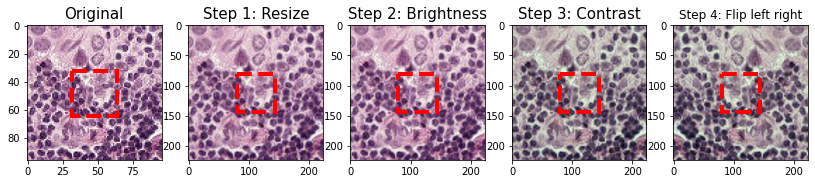

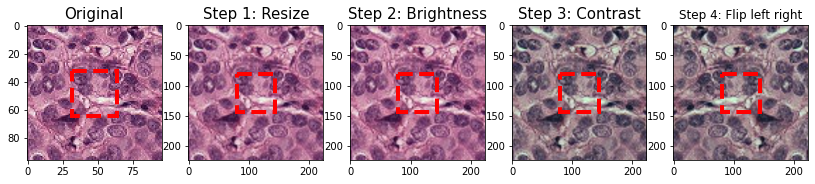

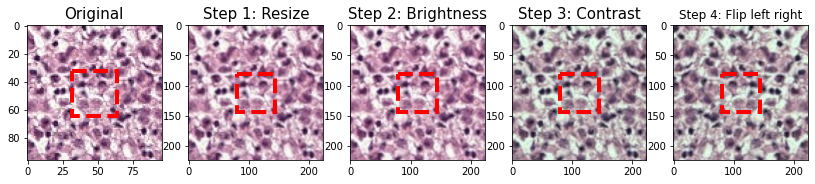

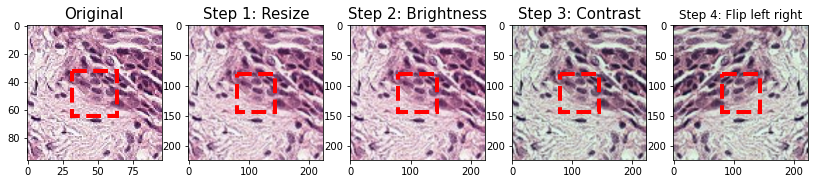

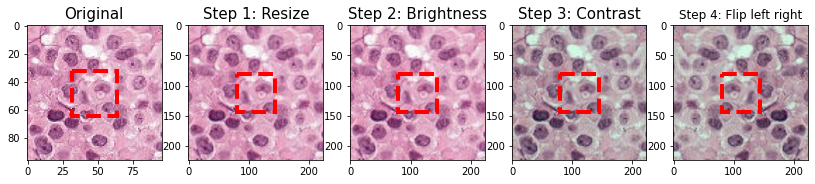

Completed getting data visualizations for train...
*****************************************************
*****************************************************


*****************************************************
*****************************************************
Starting data visualization for train and negative...
Displaying training negative images


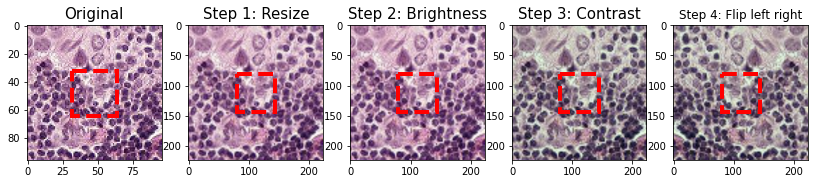

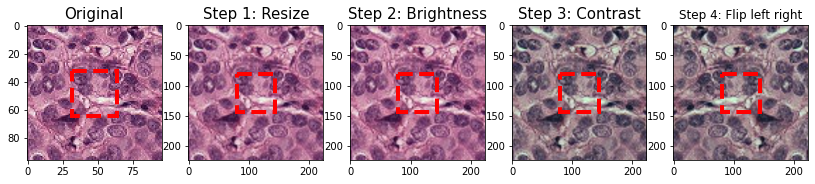

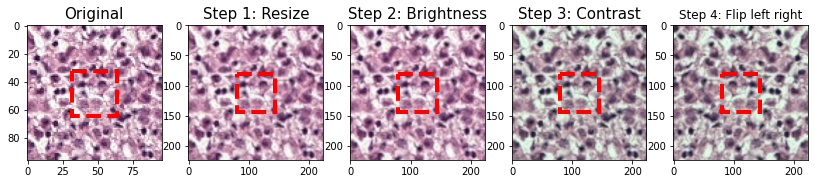

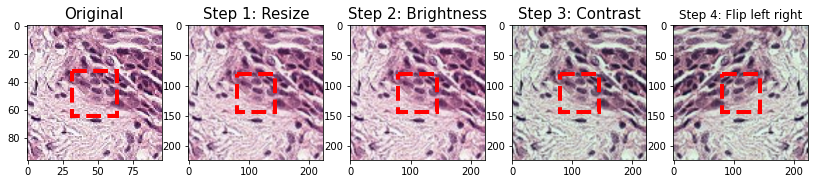

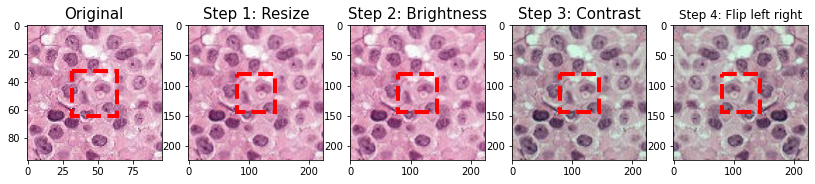

Completed getting data visualizations for train...
*****************************************************
*****************************************************



In [18]:
class data_processing:

    def __init__(self, run_mode):
        self.train_file_list = []
        self.test_file_list = []
        self.run_mode = run_mode
        np.random.seed(random_state)
                
    def get_file_names_list(self):
        """
    	  This method builds the list of train and test files.
        It also reads the original color images and save them with _gs extension 
        in the same path as the original image. The grayscale images will be 
        used for modeling whereas the color images are used for data 
        visualization purposes.
    	  """
        print()
        print("*****************************************************")
        print("*****************************************************")
        print("Starting to build fully qualified train and test file name lists...")
        # Original input images are color which we will later convert to grascale.
        self.train_file_color_list = misc_proc.get_id_and_label_list(train_files_path, image_file_extension)
        self.test_file_color_list = misc_proc.get_id_and_label_list(test_files_path, image_file_extension)
        self.train_file_list = []

        # Loading the input images as grayscale images and saving them back with 
        # "_gs" extension to distinguish.
        # We are also adding 90/180/270 deg rotation images in the train set.
        # For modeling purpose, we will use the grayscale images and 
        # for visualization purposes we will use the original color images.
        for image_file in self.train_file_color_list:

            img_gs = load_img(image_file, color_mode = "grayscale")
            img_array_gs = img_to_array(img_gs)
            save_img(image_file.split(".")[0] + 
                     '_gs' + 
                     image_file_extension, 
                     img_array_gs
                    )
            self.train_file_list.append(image_file.split(".")[0] + '_gs' + 
                                        image_file_extension
                                       )
            
        if self.run_mode == 'interim_test':
            print(f"Length of train_file_list : {len(self.train_file_list)}")
            print(f"Length of test_file_list : {len(self.test_file_list)}")
        print("Completed building train and test file name lists...")
        print("*****************************************************")
        print("*****************************************************")
        print()

    def get_label_info(self):
        """
    	  This method reads the train and test label information from 
        train_labels.csv and sample_submission.csv.
        These files have the below structure:-
        id and label.
        Corresponding to the train or test id, there will be an image file 
        prssent in the respective train oo test folder.
    	  """
        print()
        print("*****************************************************")
        print("*****************************************************")
        print("Starting to get label info...")
        self.train_label = pd.read_csv(train_label_file)
        self.test_label = pd.read_csv(test_label_file)
        if self.run_mode == 'interim_test':
            print(f"Number of train labels : {len(self.train_label)}")
            print(f"Number of test labels : {len(self.test_label)}")

        self.qualified_train_file_names_list = misc_proc.generate_fully_qualified_file_name_list(self.train_label.id.values.tolist())
        self.qualified_test_file_names_list = misc_proc.generate_fully_qualified_file_name_list(self.test_label.id.values.tolist())
        
        self.train_label_positive = self.train_label[self.train_label['label'] == 1]
        self.train_label_negative = self.train_label[self.train_label['label'] == 0]
        
        print("Completed getting label info...")
        print("*****************************************************")
        print("*****************************************************")
        print()

    def create_labels(self, train_val_test_ind, data):
        """
        This method creates label of given length.
        """
        print()
        print("*****************************************************")
        print("*****************************************************")
        print(f"Starting to create labels for {train_val_test_ind}...")
        if train_val_test_ind.lower() == 'train':
            self.y_train = np.asarray(data['label'].values.tolist())
        elif train_val_test_ind.lower() == 'test':
            self.y_test = np.asarray(data['label'].values.tolist())
        elif train_val_test_ind.lower() == 'validation':
            self.y_validation = np.asarray(data['label'].values.tolist())    
        print(f"Completed building labels for {train_val_test_ind}...")
        print("*****************************************************")
        print("*****************************************************")
        print()

    def split_data_based_on_indices(self, train_indices, validation_indices):
        """
        This method splits data based on indices.
        """
        print()
        print("*****************************************************")
        print("*****************************************************")
        print("Starting to split data based on indices...")
        # New train and validation set and corresponding labels based on the kfold split process generated indices.
        self.df_train = self.df_train_original.iloc[train_indices]
        self.df_validation = self.df_train_original.iloc[validation_indices]
        self.create_labels(train_val_test_ind = 'train', data = self.df_train)
        self.create_labels(train_val_test_ind = 'validation', data = self.df_validation)
        
        if self.run_mode == 'interim_test':
            print(f"Length of train data : {len(self.df_train)}, length of validation data : {len(self.df_validation)}, length of test data : {len(self.df_test)}")
            print(f"Length of train positive data : {len(self.df_train[self.df_train.label == 1])}, length of validation positive data : {len(self.df_validation[self.df_validation.label == 1])}, length of test positive data : {len(self.df_test[self.df_test.label == 1])}")
            print(f"Length of train negative data : {len(self.df_train[self.df_train.label == 0])}, length of validation negative data : {len(self.df_validation[self.df_validation.label == 0])}, length of test negative data : {len(self.df_test[self.df_test.label == 0])}")
        
        """
        Both df_train and df_validation have three columns id, id_gs and label.
        id is the original color file name without extension and id_gs is the
        grayscale file name, derived off id column along with a "_gs" suffix.
        For modeling purpose, we will use the _gs file and for data visulaization
        purposes, we will use the original color images.
        Thus, to move the files in a different directory, we will move the 
        grayscale images.
        """
        misc_proc.remove_files_from_dir(image_processing_train_positive_path)
        misc_proc.remove_files_from_dir(image_processing_train_negative_path)
        self.train_positive_file_list = misc_proc.generate_fully_qualified_file_name_list(self.df_train[self.df_train.label == 1].id_gs.values.tolist())
        self.train_negative_file_list = misc_proc.generate_fully_qualified_file_name_list(self.df_train[self.df_train.label == 0].id_gs.values.tolist())
        print(f"Copying test_positive_file_list under {image_processing_train_positive_path}")
        misc_proc.process_copy_files(self.train_positive_file_list, image_processing_train_positive_path)
        print(f"Copying test_negative_file_list under {image_processing_train_negative_path}")
        misc_proc.process_copy_files(self.train_negative_file_list, image_processing_train_negative_path)
        print(f"File count under {image_processing_train_positive_path} after moving new files is: {misc_proc.check_file_count_in_a_directory(image_processing_train_positive_path)}")
        print(f"File count under {image_processing_train_negative_path} after moving new files is : {misc_proc.check_file_count_in_a_directory(image_processing_train_negative_path)}")
        
        misc_proc.remove_files_from_dir(image_processing_validation_positive_path)
        misc_proc.remove_files_from_dir(image_processing_validation_negative_path)
        self.validation_positive_file_list = misc_proc.generate_fully_qualified_file_name_list(self.df_validation[self.df_validation.label == 1].id_gs.values.tolist())
        self.validation_negative_file_list = misc_proc.generate_fully_qualified_file_name_list(self.df_validation[self.df_validation.label == 0].id_gs.values.tolist())
        print(f"Copying test_positive_file_list under {image_processing_validation_positive_path}")
        misc_proc.process_copy_files(self.validation_positive_file_list, image_processing_validation_positive_path)
        print(f"Copying test_negative_file_list under {image_processing_validation_negative_path}")
        misc_proc.process_copy_files(self.validation_negative_file_list, image_processing_validation_negative_path)
        print(f"File count under {image_processing_validation_positive_path} after moving new files is: {misc_proc.check_file_count_in_a_directory(image_processing_validation_positive_path)}")
        print(f"File count under {image_processing_validation_negative_path} after moving new files is : {misc_proc.check_file_count_in_a_directory(image_processing_validation_negative_path)}")
            
        print("Completed spliting the data sets based on indices...")
        print("*****************************************************")
        print("*****************************************************")
        print()

    def initial_split_data(self):
        """
    	  This method uses train data to split into train, validation and test sets.
    	  The reason we are repurposing the train set is because we do not have labels for test data.
    	  We also see data imbalance issue and thus we are undersampling the most populated class (negative images).
    	  """
        print()
        print("*****************************************************")
        print("*****************************************************")
        print("Starting to split data...")

        """
        Extracting top sample_size records from train_label_positive and 
        train_label_negative seperately and then combine them together so 
        that distribution is uniform.
        """
        self.train_label_sample_positive = self.train_label_positive.head(sample_size)
        self.train_label_sample_negative = self.train_label_negative.head(sample_size)
        self.train_label_processed = pd.concat([self.train_label_sample_negative, 
          	                                    self.train_label_sample_positive
        	                                     ], 
        	                                     axis = 0).reset_index(drop = True)

        """
        Getting the remaining records (length of uiverse - sample size) serves
        as test data set. We have also made sure distribution is uniform here.
        """
        '''
        remaining_length = 50 #len(self.train_label_positive) - len(self.train_label_sample_positive)
        self.test_positive_df = self.train_label_positive[sample_size : sample_size + remaining_length]
        self.test_negative_df = self.train_label_negative[sample_size : sample_size + remaining_length]
        self.df_test = pd.concat([self.test_positive_df, self.test_negative_df], axis = 0).reset_index(drop = True)
        self.df_test = shuffle(self.df_test, random_state = random_state)
        self.create_labels(train_val_test_ind = 'test', data = self.df_test)
        '''

        # shuffle
        self.train_label_processed = shuffle(self.train_label_processed, random_state = random_state)
        label = self.train_label_processed['label']
        self.df_train, self.df_test = train_test_split(self.train_label_processed, 
          	                                                 test_size = 0.1, 
        	                                                   random_state = random_state, 
        	                                                   stratify = label
        	                                                  )
        self.create_labels(train_val_test_ind = 'train', data = self.df_train)
        self.create_labels(train_val_test_ind = 'test', data = self.df_test)
        self.df_train['id_gs'] = self.df_train['id'].apply(lambda x : x + '_gs')
        self.df_test['id_gs']  = self.df_test['id'].apply(lambda x : x + '_gs')
        self.df_train_original = copy.deepcopy(self.df_train)

        """
        At this point, df_test has three columns id, id_gs and label.
        id denotes original color image name without extension and id_gs is the
        grayscale image name derived off id column data, suffixed with '_gs'
        extension.
        We will use grayscale images for all our training, so while moving the
        images to appropriate directory, we need to move the grayscale images.
        """
        misc_proc.create_dir_structure(root_directory = '/content/image_processing')
        misc_proc.remove_files_from_dir(image_processing_test_positive_path)
        misc_proc.remove_files_from_dir(image_processing_test_negative_path)
        self.test_positive_file_list = misc_proc.generate_fully_qualified_file_name_list(self.df_test[self.df_test.label == 1].id_gs.values.tolist())
        self.test_negative_file_list = misc_proc.generate_fully_qualified_file_name_list(self.df_test[self.df_test.label == 0].id_gs.values.tolist())
        print(f"Copying test_positive_file_list under {image_processing_test_positive_path}")
        misc_proc.process_copy_files(self.test_positive_file_list, image_processing_test_positive_path)
        print(f"Copying test_negative_file_list under {image_processing_test_negative_path}")
        misc_proc.process_copy_files(self.test_negative_file_list, image_processing_test_negative_path)
        print(f"File count under {image_processing_test_positive_path} is {misc_proc.check_file_count_in_a_directory(image_processing_test_positive_path)}")
        print(f"File count under {image_processing_test_negative_path} is {misc_proc.check_file_count_in_a_directory(image_processing_test_negative_path)}")

        self.sample_positive_label = self.train_label_sample_positive['label'].values.tolist()
        self.sample_negative_label = self.train_label_sample_negative['label'].values.tolist()

        self.df_train_positive = self.df_train[self.df_train.label == 1]
        self.df_train_negative = self.df_train[self.df_train.label == 0]

        self.df_test_positive = self.df_test[self.df_test.label == 1]
        self.df_test_negative = self.df_test[self.df_test.label == 0]

        # Train color files
        self.train_positive_color_file_list = misc_proc.generate_fully_qualified_file_name_list(self.df_train_positive.id.values.tolist())
        self.train_negative_color_file_list = misc_proc.generate_fully_qualified_file_name_list(self.df_train_negative.id.values.tolist())

        # Test color files
        self.test_positive_color_file_list = misc_proc.generate_fully_qualified_file_name_list(self.df_test_positive.id.tolist())
        self.test_negative_color_file_list = misc_proc.generate_fully_qualified_file_name_list(self.df_test_negative.id.tolist())

        # Train grayscale files
        self.train_positive_file_list = misc_proc.generate_fully_qualified_file_name_list(self.df_train_positive.id_gs.values.tolist())
        self.train_negative_file_list = misc_proc.generate_fully_qualified_file_name_list(self.df_train_negative.id_gs.values.tolist())

        # Test grayscale files
        self.test_positive_file_list = misc_proc.generate_fully_qualified_file_name_list(self.df_test_positive.id_gs.tolist())
        self.test_negative_file_list = misc_proc.generate_fully_qualified_file_name_list(self.df_test_negative.id_gs.tolist())

        if self.run_mode == 'interim_test':
            
            print(f"Length of df_train : {len(self.df_train)}")
            print(f"Length of df_test : {len(self.df_test)}")
            print(f"Length of y_train : {len(self.y_train)}")
            print(f"Length of y_test : {len(self.y_test)}")

            print("Positive and negative images distribution in df_train")
            print(self.df_train['label'].value_counts())

            print("Positive and negative images distribution in df_test")
            print(self.df_test['label'].value_counts())

            print(f"Length of df_train_positive : {len(self.df_train_positive)}")
            print(f"Length of df_train_positive : {len(self.df_train_positive)}")

            print(f"Length of df_test_positive : {len(self.df_test_positive)}")
            print(f"Length of df_test_negative : {len(self.df_test_negative)}")

            print(f"Length of train_positive_file_list : {len(self.train_positive_file_list)}")
            print(f"Length of train_negative_file_list : {len(self.train_negative_file_list)}")

            print(f"Length of test_positive_file_list : {len(self.test_positive_file_list)}")
            print(f"Length of test_negative_file_list : {len(self.test_negative_file_list)}")

        print("Completed spliting the data sets...")
        print("*****************************************************")
        print("*****************************************************")
        print()

    def get_data_distribution(self, train_or_test_ind):
        """
     	  This method shows the distribution of positive and negative images in the data set. 
     	  """
        print()
        print("*****************************************************")
        print("*****************************************************")
        print(f"Starting to get data distributions for {train_or_test_ind}...")
        if train_or_test_ind.lower() == 'train':
            print("Data distribution in the train data set")
            print(self.train_label['label'].value_counts())
            data_viz.count_plot(data = self.train_label, 
                                 label_col = 'label',
                                 title_val = "Distribution of Labels in Train Data"
                                )
            data_viz.pie_chart_plot(data = self.train_label, 
                                     label_col = 'label',
                                     title_val = "Train Label Percentage Pie Chart"
                                    )
        elif train_or_test_ind.lower() == 'test':
            print("Data distribution in the test data set")
            print(self.test_label['label'].value_counts())  
            data_viz.count_plot(data = self.test_label, 
                                 label_col = 'label',
                                 title_val = "Distribution of Labels in Test Data"
                                )
            data_viz.pie_chart_plot(data = self.test_label, 
                                     label_col = 'label',
                                     title_val = "Test Label Percentage Pie Chart"
                                    )
        print(f"Completed getting data distributions for {train_or_test_ind}...")
        print("*****************************************************")
        print("*****************************************************")
        print()

    def check_duplicate_ids(self, train_or_test_ind):
        """
    	  This method checks if there is any duplicate ids in the data set.
    	  """
        print()
        print("*****************************************************")
        print("*****************************************************")
        print(f"Starting to check duplicates for {train_or_test_ind}...")
        if train_or_test_ind.lower() == 'train':
            df_train_id_count = pd.DataFrame(self.train_label.groupby(['id'])['id'].count())
            df_train_id_count.columns = ['id_count']
            df_train_id_count.reset_index(inplace = True)
            print("Number of train duplicate entries : ", len(df_train_id_count[df_train_id_count.id_count > 1]))
        elif train_or_test_ind.lower() == 'test':
            df_test_id_count = pd.DataFrame(self.test_label.groupby(['id'])['id'].count())
            df_test_id_count.columns = ['id_count']
            df_test_id_count.reset_index(inplace = True)
            print("Number of test duplicate entries : ", len(df_test_id_count[df_test_id_count.id_count > 1]))
        print(f"Completed checking duplicates for {train_or_test_ind}...")
        print("*****************************************************")
        print("*****************************************************")
        print()

    def data_visualization(self, train_or_test_ind, positive_or_negative_ind, image_list, number_of_images = 5):
        """
        This method visualizes the data.
        """
        print()
        print("*****************************************************")
        print("*****************************************************")
        print(f"Starting data visualization for {train_or_test_ind} and {positive_or_negative_ind}...")
        if train_or_test_ind.lower() == 'train':
            print(f"Displaying training {positive_or_negative_ind.lower()} images")
        if train_or_test_ind.lower() == 'test':
            print(f"Displaying test {positive_or_negative_ind.lower()} images")

        for image in image_list[:number_of_images]:
            misc_proc.print_image_in_diff_orientation(image)
            plt.show(block = False)

        print(f"Completed getting data visualizations for {train_or_test_ind}...")
        print("*****************************************************")
        print("*****************************************************")
        print()

    def get_image_summary_stats(self):
        """
        This method gets positive and negative images summary stats at the picture level and each color (R, G, B) channel level.
        """
        print()
        print("*****************************************************")
        print("*****************************************************")
        print("Starting to get positive and negative images summary stats...")

        # Whole image wise stats
        print("Mean and standard deviation at center for positive train images: ", misc_proc.compute_mean_and_std(self.train_positive_color_file_list))
        print("Mean and standard deviation at center for negative train images: ", misc_proc.compute_mean_and_std(self.train_negative_color_file_list))

        number_of_bins = 64 
        figw, axw = plt.subplots(1,2, sharey = True, sharex = True, figsize = (8,2), dpi = 150)
        axw[0].hist(img_proc.read_image_file_in_np_array(self.train_positive_color_file_list)[:,:,:,(0,1,2)].flatten(),
                                                        bins = number_of_bins, 
                                                        density = True);
        axw[1].hist(img_proc.read_image_file_in_np_array(self.train_negative_color_file_list)[:,:,:,(0,1,2)].flatten(),
                                                        bins = number_of_bins, 
                                                        density = True);

        axw[0].set_title("Train positive images");
        axw[1].set_title("Train negative images");

        axw[0].set_xlabel("Mean brightness")
        axw[1].set_xlabel("Mean brightness")
        axw[0].set_ylabel("Relative frequency")
        axw[1].set_ylabel("Relative frequency")
        plt.show(block = False);

        # Channel wise stats
        print("Average across red, green and blue channels for train positive images")
        print(np.mean(img_proc.read_image_file_in_np_array(self.train_positive_color_file_list), axis = (0,1,2)))
        print("Standard Deviation across red, green and blue channels for Train positive images")
        print(np.std(img_proc.read_image_file_in_np_array(self.train_positive_color_file_list), axis = (0,1,2)))

        print("Average across red, green and blue channels for train X_train_img_file_negative images")
        print(np.mean(img_proc.read_image_file_in_np_array(self.train_negative_color_file_list), axis = (0,1,2)))
        print("Standard Deviation across red, green and blue channels for train X_train_img_file_negative images")
        print(np.std(img_proc.read_image_file_in_np_array(self.train_negative_color_file_list), axis = (0,1,2)))

        # Red Channel
        figr, axr = plt.subplots(1,2, sharey = True, sharex = True, figsize = (8,2), dpi = 150)
        axr[0].hist(img_proc.read_image_file_in_np_array(self.train_positive_color_file_list)[:,:,:,(0)].flatten(),
                                                        bins = number_of_bins, 
                                                        density = True);
        axr[1].hist(img_proc.read_image_file_in_np_array(self.train_negative_color_file_list)[:,:,:,(0)].flatten(),
                                                        bins = number_of_bins, 
                                                        density = True);

        axr[0].set_title("Train positive images");
        axr[1].set_title("Train negative images");

        axr[0].set_xlabel("Mean red brightness")
        axr[1].set_xlabel("Mean red brightness")
        axr[0].set_ylabel("Relative frequency")
        axr[1].set_ylabel("Relative frequency")
        plt.show(block = False);

        # Green Channel
        figg, axg = plt.subplots(1,2, sharey = True, sharex = True, figsize = (8,2), dpi = 150)
        axg[0].hist(img_proc.read_image_file_in_np_array(self.train_positive_color_file_list)[:,:,:,(1)].flatten(),
                                                        bins = number_of_bins, 
                                                        density = True);
        axg[1].hist(img_proc.read_image_file_in_np_array(self.train_negative_color_file_list)[:,:,:,(1)].flatten(),
                                                        bins = number_of_bins, 
                                                        density = True);

        axg[0].set_title("Train positive images");
        axg[1].set_title("Train negative images");

        axg[0].set_xlabel("Mean green brightness")
        axg[1].set_xlabel("Mean green brightness")
        axg[0].set_ylabel("Relative frequency")
        axg[1].set_ylabel("Relative frequency")
        plt.show(block = False);

        # Blue Channel
        figb, axb = plt.subplots(1,2, sharey = True, sharex = True, figsize = (8,2), dpi = 150)
        axb[0].hist(img_proc.read_image_file_in_np_array(self.train_positive_color_file_list)[:,:,:,(2)].flatten(),
                                                        bins = number_of_bins, 
                                                        density = True);
        axb[1].hist(img_proc.read_image_file_in_np_array(self.train_negative_color_file_list)[:,:,:,(2)].flatten(),
                                                        bins = number_of_bins, 
                                                        density = True);

        axb[0].set_title("Train positive images");
        axb[1].set_title("Train negative images");

        axb[0].set_xlabel("Mean blue brightness")
        axb[1].set_xlabel("Mean blue brightness")
        axb[0].set_ylabel("Relative frequency")
        axb[1].set_ylabel("Relative frequency")
        plt.show(block = False);

        print(f"Completed get positive and negative images summary stats...")
        print("*****************************************************")
        print("*****************************************************")
        print()

    def data_processing_pipeline(self):
        """
        This method performs required data processing steps.
        """
        print()
        print("*****************************************************")
        print("*****************************************************")
        print("Starting data processing pipeline...")
        self.get_file_names_list()
        self.get_label_info()
        self.initial_split_data()
        
        if self.run_mode == 'interim_test':
            self.check_duplicate_ids('train')
            self.check_duplicate_ids('test')
            self.get_data_distribution('train')
            self.get_data_distribution('test')
            self.get_image_summary_stats()
            
        #self.move_files()
        print("Completed data processing pipeline...")
        print()
        print("*****************************************************")
        print("*****************************************************")

'''
data_proc = data_processing(run_mode = 'final_test')
'''
# Used for testing
#data_proc = data_processing(run_mode = 'interim_test') 
data_proc = data_processing(run_mode = 'final_test')
data_proc.data_processing_pipeline()

# Data visualizations
data_proc.data_visualization(train_or_test_ind = 'train', positive_or_negative_ind = 'positive', image_list = data_proc.train_positive_color_file_list)
data_proc.data_visualization(train_or_test_ind = 'train', positive_or_negative_ind = 'negative', image_list = data_proc.train_positive_color_file_list)

In [19]:
print(f"Length of train data : {len(data_proc.df_train)}")
print(f"Length of test data : {len(data_proc.df_test)}")

Length of train data : 144000
Length of test data : 16000


# ***3. Model Building***

In [20]:
def soft_voting_cllasifier(df):
    """
    This function selects final class probability and final class label 
    across multiple folds based on the average positive and negative 
    probability values thru soft voting process.
    """
    clf_list = []
    for pos in df['y_test_index'].drop_duplicates().tolist():
        #print(f"pos : {pos}")
        pos_val, neg_val = [],[]
        pos_proba, neg_proba = 0,0
        for rec in df[df.y_test_index == pos].values.tolist():
            #print(rec)
            y_test_index = rec[0]
            sigmoid_val = rec[1]
            th50_bin_pred_val = rec[2]
            actual_val = rec[3]
            kfold = rec[4]
            if int(th50_bin_pred_val) == 0:
                neg_val.append(sigmoid_val)
            else:
                pos_val.append(sigmoid_val)
        
        #print(sum(pos_val) , len(pos_val), sum(neg_val) , len(neg_val))
        # Unanimously negative
        if len(pos_val) == 0:
            pos_proba = 0
        else:
            pos_proba = sum(pos_val) / len(pos_val)
        # Unanimously positive
        if len(neg_val) == 0:
            neg_proba == 0
        else:
            neg_proba = sum(neg_val) / len(neg_val)
        assigned_proba = np.max(np.asarray([pos_proba, neg_proba]))
        if  np.where(np.asarray([pos_proba, neg_proba]) == assigned_proba)[0][0] == 0:
            assigned_bin = 1
        else:
            assigned_bin = 0
        #print(pos, assigned_proba,  assigned_bin)
        clf_list.append((pos, assigned_proba,  assigned_bin))
        #print("***")
    df_clf = pd.DataFrame(clf_list, columns = ['y_test_index', 
                                               'assigned_probability', 
                                               'assigned_binary_value'
                                              ]
                         ).drop_duplicates()
    df_actual = df[['y_test_index', 'actual_val']].drop_duplicates()
    df_clf = pd.merge(df_clf, df_actual, how = 'inner', on = 'y_test_index')
    df_clf['actual_val'] = df_clf['actual_val'].astype(int)
    return df_clf

In [21]:
def hard_voting_cllasifier(df):
    """
    This function selects final class probability and final class label 
    across multiple folds based on the majority class count thru the hard voting
    process. In case of a tie, it selects positive class unlike sklearn
    implementation where it picks up the record with min class value.
    """
    agg_df = df.groupby(['y_test_index']).agg({'th50_bin_pred_val': [np.size, np.min, np.max, stats.mode]}).reset_index()
    agg_df.columns = ['y_test_index', 
                      'th50_bin_pred_val_count', 
                      'th50_bin_pred_val_min', 
                      'th50_bin_pred_val_max',
                      'pred_bin'
                     ]
    agg_df[['majority_class_value', 'majority_count']] = pd.DataFrame(agg_df['pred_bin'].tolist(), index = agg_df.index)
    agg_df['majority_class_value'] = agg_df['majority_class_value'].apply(lambda x : x[0])
    agg_df['majority_count'] = agg_df['majority_count'].apply(lambda x : x[0])
    agg_df['assigned_binary_value'] = np.where((agg_df['th50_bin_pred_val_min'] == agg_df['th50_bin_pred_val_max']) | (agg_df['majority_count'] < number_of_splits), agg_df['majority_class_value'], -1)
    agg_df['assigned_binary_value'] = np.where(agg_df['majority_count'] * 2 == agg_df['th50_bin_pred_val_count'], 1, agg_df['assigned_binary_value'])

    clf_list = []
    for rec in agg_df[['y_test_index', 'assigned_binary_value']].values.tolist():
        avg_sigmoid_val = consolidated_pred_df[(consolidated_pred_df.y_test_index == rec[0]) & (consolidated_pred_df.th50_bin_pred_val == rec[1])]['sigmoid_val'].mean()
        clf_list.append((rec[0], avg_sigmoid_val, rec[1]))
    df_clf = pd.DataFrame(clf_list)
    df_clf.columns   = ['y_test_index', 
                        'assigned_probability', 
                        'assigned_binary_value'
                       ]
    df_clf['y_test_index'] = df_clf['y_test_index'].apply(lambda x : int(x))
    df_clf = pd.merge(df_clf, 
                      df[['y_test_index', 'actual_val']].drop_duplicates(), 
                      how = 'inner', 
                      on = 'y_test_index'
                     )
    df_clf['actual_val'] = df_clf['actual_val'].astype(int)
    return df_clf

In [ ]:
# Data generators

'''
rotation rules
(x, y) -90->  (-y, x)
(x, y) -180-> (-x, -y)
(x, y) -270-> (y, -x)
(x, y) 90-> (y, -x)
(x, y) 180-> (-x, -y)
(x, y) 270-> (-y, x)
'''

consolidated_history_df = pd.DataFrame()
consolidated_test_kpi_df = pd.DataFrame()
test_kpi_df = pd.DataFrame()
temp_pred_df = pd.DataFrame()
consolidated_pred_df = pd.DataFrame()

pred_list = []
def custom_augmentation(np_tensor):
 
    def random_contrast(np_tensor):
        return tf.image.random_contrast(np_tensor, 0.1, 5)
 
    def random_hue(np_tensor):
        return tf.image.random_hue(np_tensor, 0.5)
 
    def random_saturation(np_tensor):
        return tf.image.random_saturation(np_tensor, 0.2, 3)
 
    def gaussian_noise(np_tensor):
        mean = 0
        # variance: randomly between 1 to 25
        var = np.random.randint(1, 26)
        # sigma is square root of the variance value
        noise = np.random.normal(mean,var**0.5,np_tensor.shape)
        return np.clip(np_tensor + noise, 0, 255).astype('int')

    augmnted_tensor = random_contrast(np_tensor)
    #augmnted_tensor = random_hue(augmnted_tensor)
    #augmnted_tensor = random_saturation(augmnted_tensor)
    #augmented_tensor = gaussian_noise(augmnted_tensor)
  
    return np.array(augmnted_tensor)

# Train data generator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   rotation_range = 180,
                                   zoom_range = 0.4, 
                                   width_shift_range = 0.3,
                                   height_shift_range = 0.3,
                                   shear_range = 0.3
                                   ,preprocessing_function = custom_augmentation 
                                  )

# Validation data generator
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1.0/255
    )

# Test data generator
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1.0/255
    )

# Stores each model and kfold specific train and validation accuracies 
# and losses for each epoch
temp_df_model_kpi = pd.DataFrame()
# Consolidates the above results across all model and kfolds.
consolidated_df_model_kpi = pd.DataFrame()

# Holds model and kfold specific actual, prediction %, perdiction binary value
# along with test loss and accuracy.
temp_df_acttual_vs_pred_bin_pred_pct = pd.DataFrame()
# Consolidates the above result for each model and kfold.
df_actual_vs_pred_bin_pred_pct = pd.DataFrame()

df_kfold_ensemble_stats = pd.DataFrame()
test_result_list = []

for kfold, (train_indices, validation_indices) in enumerate(StratifiedKFold(n_splits =  number_of_splits, 
                                                                                shuffle = True, 
                                                                                random_state = random_state
                                                                               ).split(data_proc.df_train_original['label'].values.tolist(), 
                                                                                       data_proc.df_train_original['label'].values.tolist()
                                                                                      )):
    print(f"k-fold : {kfold + 1}, length of train data : {len(train_indices)}, length of validation data : {len(validation_indices)}")
    data_proc.split_data_based_on_indices(train_indices = train_indices, validation_indices = validation_indices)

    train_dataset_from_data_generator = train_datagen.flow_from_directory(image_processing_train_path,
                                                                          target_size = (image_size, image_size),
                                                                          class_mode = 'binary',
                                                                          batch_size = batch_size,
                                                                          color_mode = 'rgb',
                                                                          shuffle = True,
                                                                          seed = random_state
                                                                         )
    validation_dataset_from_data_generator = val_datagen.flow_from_directory(image_processing_validation_path,
                                                                             target_size = (image_size, image_size),
                                                                             class_mode = 'binary',
                                                                             batch_size = batch_size,
                                                                             color_mode = 'rgb',
                                                                             shuffle = True,
                                                                             seed = random_state
                                                                           )
    test_dataset_from_data_generator = test_datagen.flow_from_directory(image_processing_test_path,
                                                                        target_size = (image_size, image_size),
                                                                        batch_size = batch_size,
                                                                        class_mode = 'binary',
                                                                        color_mode = 'rgb',
                                                                        shuffle = False,
                                                                        seed = random_state
                                                                       )
        
    tf.random.set_seed(random_state)
    np.random.seed(random_state)

    input_shape = (image_size, image_size, 3)
    inputs = Input(input_shape)

    inceptionresnetv2 = InceptionResNetV2(weights = 'imagenet', 
                                          include_top = False)
    inceptionresnetv2.trainable = True

    # add a global spatial average pooling layer
    internal_layers = inceptionresnetv2.output
    internal_layers = GlobalAveragePooling2D()(internal_layers)
    # let's add a fully-connected layer
    internal_layers = Dense(1024, 
                            activation = 'relu')(internal_layers)
    # and a logistic layer -- let's say we have 200 classes
    predictions = Dense(1, activation = None)(internal_layers)
    model = Model(inputs  = inceptionresnetv2.input, 
                  outputs = predictions)
    
    model.compile(optimizer = Adam(learning_rate = 0.0001, 
                                   decay = 0.00001
                                  ),
                  loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
                  metrics = ['accuracy']
                  )
    model.summary()
    tf.keras.utils.plot_model(model, 
                              to_file='model_structure.png', 
                              show_shapes = True,
                              show_layer_names = True)
    plt.show(block = False)

    history = model.fit(train_dataset_from_data_generator,
                        epochs = epochs,
                        steps_per_epoch = len(train_dataset_from_data_generator),
                        validation_data = validation_dataset_from_data_generator,
                        validation_steps = len(validation_dataset_from_data_generator),
                        verbose = 1
                      )

    
    # Model save
    print("Saving model...")
    tf.keras.backend.clear_session()
    gc.collect()
    model_name = f'tumor_detection_inceptionrestnetv2_{kfold + 1}'
    model.save(model_name + '.h5')
    tf.keras.backend.clear_session()
    gc.collect()
    
    # Collecting train and validation metrices and append it back to consolidated one
    temp_result_df = pd.DataFrame()
    temp_result_df = pd.DataFrame(history.history)
    temp_result_df['kfold'] = kfold + 1
    consolidated_history_df = pd.concat([temp_result_df, 
                                         consolidated_history_df
                                        ], 
                                        axis = 0
                                       )

    model_proc.plot_model_accuracy_and_loss(history = history, 
                                            model_name = 'inceptionrestnetv2'
                                           )

    # Model Predict, transform logits to probabilities
    step_size_test = np.ceil(test_dataset_from_data_generator.n / test_dataset_from_data_generator.batch_size)
    test_dataset_from_data_generator.reset()
    pred_logits = model.predict(test_dataset_from_data_generator, steps = step_size_test, verbose = 1)
    probas_sigmoid = tf.sigmoid(pred_logits)
    probas_sigmoid = np.round(probas_sigmoid.numpy().flatten() * 100)
    predictions_binary_th50 = [1 if x > 50.0 else 0 for x in probas_sigmoid]
    
    #predictions_binary_th60 = [1 if x > 60.0 else 0 for x in probas_sigmoid]
    #predictions_binary_th75 = [1 if x > 75.0 else 0 for x in probas_sigmoid]
    
    print("Confusion matrix with 50% threshold")
    model_proc.plot_model_result_confusion_matrix(threshold_val = 50.0, 
                                                  y_pred_probas = probas_sigmoid, 
                                                  y_test = data_proc.y_test
                                                 )

    print("Plot AOC-AUC")
    model_proc.plot_roc_auc_curve(y_pred_probas = probas_sigmoid, 
                                  y_test = data_proc.y_test
                                 )
    
    print(f"Classification report with 50% threshold")
    model_proc.generate_report(threshold_val = 50.0, 
                               y_pred_probas = probas_sigmoid, 
                               y_test = data_proc.y_test
                              )
    
    temp_pred_df = pd.DataFrame(np.transpose([probas_sigmoid, 
                                              predictions_binary_th50,
                                              #predictions_binary_th60,
                                              #predictions_binary_th75, 
                                              data_proc.y_test
                                             ]
                                            )
                               )
    temp_pred_df.columns = ['sigmoid_val', 
                            'th50_bin_pred_val', 
                            #'th60_bin_pred_val', 
                            #'th75_bin_pred_val', 
                            'actual_val'
                           ]
    temp_pred_df['kfold'] = kfold + 1
    temp_pred_df.insert(0, 'y_test_index', range(1, 1 + len(temp_pred_df)))
    print(f"Test Data Match Stats for {kfold + 1}")
    print(len(temp_pred_df), 
          len(temp_pred_df[temp_pred_df.th50_bin_pred_val == temp_pred_df.actual_val])
         )
    consolidated_pred_df = pd.concat([temp_pred_df, 
                                      consolidated_pred_df
                                     ], 
                                    axis = 0)
    #test_loss, test_accuracy, test_precission, test_recall, test_auc = model.evaluate(test_dataset_from_data_generator, verbose = 0)
    test_loss, test_accuracy = model.evaluate(test_dataset_from_data_generator, verbose = 0)
    # accuracy: (tp + tn) / (p + n)
    # precision tp / (tp + fp)
    # recall: tp / (tp + fn)
    # f1: 2 tp / (2 tp + fp + fn)
    test_precision = precision_score(predictions_binary_th50, data_proc.y_test)
    test_recall = recall_score(predictions_binary_th50, data_proc.y_test)
    test_f1_score = f1_score(predictions_binary_th50, data_proc.y_test)
    fpr, tpr, thresholds = roc_curve(data_proc.y_test, probas_sigmoid)
    test_auc_val = auc(fpr, tpr)
    print(f"Test Loss : {test_loss}")
    print(f"Test Accuracy : {test_accuracy}")
    print(f"Test Precision : {test_precision}")
    print(f"Test Recall : {test_recall}")
    print(f"Test F1 Score : {test_f1_score}")
    print(f"Test AUC Score : {test_auc_val}")

    print("********************************************")
    print("********************************************")
    test_kpi_df = pd.DataFrame([kfold + 1,
                                test_loss, 
                                test_accuracy,
                                test_precision,
                                test_recall,
                                test_f1_score,
                                test_auc_val,
                               ]).T
    test_kpi_df.columns = ['kfold', 
                           'test_loss', 
                           'test_accuracy',
                           'test_precission',
                           'test_recall',
                           'test_f1',
                           'test_auc'
                          ]
    consolidated_test_kpi_df = pd.concat([test_kpi_df, 
                                          consolidated_test_kpi_df
                                         ], 
                                         axis = 0
                                       )

k-fold : 1, length of train data : 108000, length of validation data : 36000

*****************************************************
*****************************************************
Starting to split data based on indices...

*****************************************************
*****************************************************
Starting to create labels for train...
Completed building labels for train...
*****************************************************
*****************************************************


*****************************************************
*****************************************************
Starting to create labels for validation...
Completed building labels for validation...
*****************************************************
*****************************************************


*****************************************************
*****************************************************
Starting to remove files under /content/image_processing/tra

In [ ]:
consolidated_test_kpi_df.head()

In [ ]:
consolidated_test_kpi_df.describe()

In [ ]:
consolidated_history_df.head()

In [ ]:
consolidated_history_df.describe()

In [ ]:
consolidated_pred_df.head()

In [ ]:
consolidated_pred_df.describe()

In [ ]:
consolidated_history_df.to_csv('consolidated_history.csv', index = False)
consolidated_test_kpi_df.to_csv('consolidated_test_kpi.csv', index = False)
consolidated_pred_df.to_csv('consolidated_pred.csv', index = False)

In [ ]:
print("Calling ensemble soft voting...")
df_soft_voting_clf = soft_voting_cllasifier(consolidated_pred_df)
df_soft_voting_clf.head()

In [ ]:
final_accuracy_soft_voting = accuracy_score(data_proc.y_test, df_soft_voting_clf['assigned_binary_value'].values.tolist())
final_precision_soft_voting = precision_score(df_soft_voting_clf['assigned_binary_value'].values.tolist(), data_proc.y_test)
final_recall_soft_voting = recall_score(df_soft_voting_clf['assigned_binary_value'].values.tolist(), data_proc.y_test)
final_f1_score_soft_voting = f1_score(df_soft_voting_clf['assigned_binary_value'].values.tolist(), data_proc.y_test)
fpr, tpr, thresholds = roc_curve(data_proc.y_test, df_soft_voting_clf['assigned_probability'].values.tolist())
final_auc_val_soft_voting = auc(fpr, tpr)
print(f"Final Ensemble Accuracy : {final_accuracy_soft_voting}")
print(f"Final Ensemble Precision : {final_precision_soft_voting}")
print(f"Final Ensemble Recall : {final_recall_soft_voting}")
print(f"Final Ensemble F1 Score : {final_f1_score_soft_voting}")
print(f"Final Ensemble AUC Score : {final_auc_val_soft_voting}")

In [ ]:
df_soft_voting_clf['final_accuracy_soft_voting'] = final_accuracy_soft_voting
df_soft_voting_clf['final_precision_soft_voting'] = final_precision_soft_voting
df_soft_voting_clf['final_recall_soft_voting'] = final_recall_soft_voting
df_soft_voting_clf['final_auc_val_soft_voting'] = final_auc_val_soft_voting
df_soft_voting_clf['final_f1_score_soft_voting'] = final_f1_score_soft_voting
df_soft_voting_clf.to_csv('soft_voting_clf_result.csv', index = False)

In [ ]:
len(df_soft_voting_clf[df_soft_voting_clf.assigned_binary_value == df_soft_voting_clf.actual_val.astype(int)]), len(df_soft_voting_clf[df_soft_voting_clf.assigned_binary_value != df_soft_voting_clf.actual_val.astype(int)])

In [ ]:
print("Calling ensemble hard voting...")
df_hard_voting_clf = hard_voting_cllasifier(consolidated_pred_df)
df_hard_voting_clf.head()

In [ ]:
final_accuracy_hard_voting = accuracy_score(data_proc.y_test, df_hard_voting_clf['assigned_binary_value'].values.tolist())
final_precision_hard_voting = precision_score(df_hard_voting_clf['assigned_binary_value'].values.tolist(), data_proc.y_test)
final_recall_hard_voting = recall_score(df_hard_voting_clf['assigned_binary_value'].values.tolist(), data_proc.y_test)
final_f1_score_hard_voting = f1_score(df_hard_voting_clf['assigned_binary_value'].values.tolist(), data_proc.y_test)
fpr, tpr, thresholds = roc_curve(data_proc.y_test, df_hard_voting_clf['assigned_probability'].values.tolist())
final_auc_val_hard_voting = auc(fpr, tpr)
print(f"Final Ensemble Accuracy : {final_accuracy_hard_voting}")
print(f"Final Ensemble Precision : {final_precision_hard_voting}")
print(f"Final Ensemble Recall : {final_recall_hard_voting}")
print(f"Final Ensemble F1 Score : {final_f1_score_hard_voting}")
print(f"Final Ensemble AUC Score : {final_auc_val_hard_voting}")

In [ ]:
len(df_hard_voting_clf[df_hard_voting_clf.assigned_binary_value == df_hard_voting_clf.actual_val.astype(int)]), len(df_hard_voting_clf[df_hard_voting_clf.assigned_binary_value != df_hard_voting_clf.actual_val.astype(int)])

In [ ]:
df_hard_voting_clf['final_accuracy_soft_voting'] = final_accuracy_hard_voting
df_hard_voting_clf['final_precision_soft_voting'] = final_precision_hard_voting
df_hard_voting_clf['final_recall_soft_voting'] = final_recall_hard_voting
df_hard_voting_clf['final_auc_val_soft_voting'] = final_auc_val_hard_voting
df_hard_voting_clf['final_f1_score_soft_voting'] = final_f1_score_hard_voting
df_hard_voting_clf.to_csv('hard_voting_clf_result.csv', index = False)

In [ ]:
pd.concat([df_soft_voting_clf, df_hard_voting_clf], axis = 1)

In [ ]:
test_img = load_img(data_proc.train_file_list[0], color_mode ="grayscale")
test_img_arry = img_to_array(test_img)
print(type(test_img))
print(test_img.format)
print(test_img.mode)
print(test_img.size)
print(test_img.getbands())
print(test_img_arry.shape)

test_img1 = load_img(data_proc.train_file_list[0])
test_img1_arry = img_to_array(test_img1)
print(test_img1_arry.shape)
print(test_img1.getbands())

<class 'PIL.TiffImagePlugin.TiffImageFile'>
TIFF
L
(96, 96)
('L',)
(96, 96, 1)
(96, 96, 3)
('R', 'G', 'B')
